[![Binder](https://mybinder.org/badge_logo.svg)](https://nbviewer.org/github/vicente-gonzalez-ruiz/scalar_quantization/blob/master/docs/KMeans_quantization.ipynb)

[![Colab](https://badgen.net/badge/Launch/on%20Google%20Colab/blue?icon=notebook)](https://colab.research.google.com/github/vicente-gonzalez-ruiz/scalar_quantization/blob/master/docs/KMeans_quantization.ipynb)

# Quantization using KMeans clustering

* See [LloydMax_quantization.ipynb](https://github.com/vicente-gonzalez-ruiz/scalar_quantization/blob/master/docs/LloydMax_quantization.ipynb).
* KMeans is a clustering algorithm that minimizes the variance in each cluster, given a number of clusters and a set of (in general, N-dimensional) ot points (samples in the case of signal quantization).
* The Lloyd-Max quantizer can be also determined using [KMeans clustering](https://en.wikipedia.org/wiki/K-means_clustering) where the dimension of the points is 1.
* An implementation of KMeans can be found in [scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans).

In [1]:
try:
    import matplotlib.pyplot as plt
except:
    !pip install matplotlib
    import matplotlib
    import matplotlib.pyplot as plt
    import matplotlib.axes as ax
    #plt.rcParams['text.usetex'] = True
    #plt.rcParams['text.latex.preamble'] = [r'\usepackage{amsmath}'] #for \text command
%matplotlib inline

In [2]:
try:
    from sklearn.cluster import KMeans
    from sklearn.utils import shuffle
except:
    !pip install scikit-learn
    from sklearn.cluster import KMeans
    from sklearn.utils import shuffle

In [3]:
try:
    from skimage import io
except:
    !pip install scikit-image
    from skimage import io

## Build a quantizer

### Define a signal

In [4]:
import numpy as np
x = np.linspace(0, 255, 256)
x

array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
        11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,
        22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,
        33.,  34.,  35.,  36.,  37.,  38.,  39.,  40.,  41.,  42.,  43.,
        44.,  45.,  46.,  47.,  48.,  49.,  50.,  51.,  52.,  53.,  54.,
        55.,  56.,  57.,  58.,  59.,  60.,  61.,  62.,  63.,  64.,  65.,
        66.,  67.,  68.,  69.,  70.,  71.,  72.,  73.,  74.,  75.,  76.,
        77.,  78.,  79.,  80.,  81.,  82.,  83.,  84.,  85.,  86.,  87.,
        88.,  89.,  90.,  91.,  92.,  93.,  94.,  95.,  96.,  97.,  98.,
        99., 100., 101., 102., 103., 104., 105., 106., 107., 108., 109.,
       110., 111., 112., 113., 114., 115., 116., 117., 118., 119., 120.,
       121., 122., 123., 124., 125., 126., 127., 128., 129., 130., 131.,
       132., 133., 134., 135., 136., 137., 138., 139., 140., 141., 142.,
       143., 144., 145., 146., 147., 148., 149., 15

### Create the KMeans clusterer

In [5]:
clusterer = KMeans(n_clusters=2, random_state=0)

### Perform the clustering

In [6]:
clusterer.fit(x.reshape(-1, 1))
print('centroids', clusterer.cluster_centers_)

centroids [[191.5]
 [ 63.5]]


/home/vruiz/enviroments/SM/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


## Quantize an image

In [7]:
fn = "http://www.hpca.ual.es/~vruiz/images/lena.png"
img = io.imread(fn)

### Histogram of the image

In [8]:
histogram, bin_edges = np.histogram(img, bins=256, range=(0, 256))
#histogram[histogram==0] = 1
print(histogram, bin_edges)
print(len(histogram))

[   0    1    0   10   78  127  151  245  344  454  508  659  891  992
 1030 1270 1541 1757 1560 1988 1879 2049 1945 1910 2142 2080 1864 1826
 1788 1632 1667 1717 1307 1346 1238 1292 1055 1009 1059 1102  989  982
  941  980  999  982 1113  997 1146 1128 1188 1533 1330 1607 1935 2231
 2446 2844 2977 3537 3818 4099 4404 4982 4678 4962 4643 4970 4640 4767
 4713 4997 4701 4953 4823 5107 5143 5040 5179 5279 5018 5416 5125 5546
 5246 5512 5662 5805 6179 6257 6107 6569 6708 6408 6640 6547 6622 6561
 5934 6468 5802 5781 5593 5894 5358 5468 4949 5054 5108 4922 4860 4795
 5044 5082 4703 5036 5018 5109 4992 5105 5263 5455 4782 5046 5313 5292
 4863 4647 4855 4750 4219 4599 4025 3965 3912 3929 3774 3701 3327 3310
 3181 3035 2983 3025 2776 2812 2566 2847 2419 2520 2617 2697 2530 2604
 2655 2680 2518 2561 2693 2865 2384 2614 2412 2500 2247 2402 2274 2485
 2285 2510 2463 2684 2781 2827 2886 2907 3157 3016 2739 2964 2731 2858
 2702 2658 2859 2803 2692 2715 2904 2903 2750 2726 2932 2998 2698 2993
 2706 

### Build a quantizer

In [9]:
N_bins = 16
flatten_img = img.reshape((-1, 1))
clusterer = KMeans(n_clusters=N_bins, random_state=0)
clusterer.fit(flatten_img)
centroids = clusterer.cluster_centers_.squeeze()

/home/vruiz/enviroments/SM/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [10]:
print(centroids, len(centroids))

[ 96.32758188 192.57991521  18.90453139 146.15801871  70.58435211
 237.57164984 120.03901721 162.33296568 206.94940454 221.93287032
 108.33595702  57.11444072 131.59716673  84.23930265  34.78097947
 177.96873532] 16


### Encode

In [11]:
def encode(clusterer, x):
    k = clusterer.predict(x.reshape((-1, 1)))
    k.shape = x.shape
    return k

In [12]:
#k = clusterer.labels_.reshape(img.shape)
k = encode(clusterer, img)

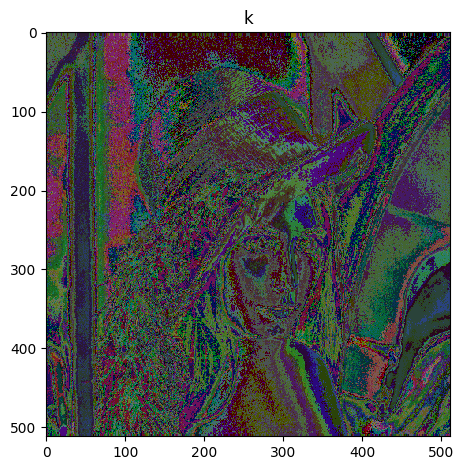

In [13]:
#gray_image.show_normalized(k, "k")
plt.figure()
plt.title('k')
io.imshow(k/np.linalg.norm(k)*255)
plt.show()

### Decode

In [14]:
def decode(clusterer, k):
    y = clusterer.cluster_centers_.squeeze()[k]
    return y

In [15]:
#y = centroids[k]
y = decode(clusterer, k)

/home/vruiz/enviroments/SM/lib/python3.10/site-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


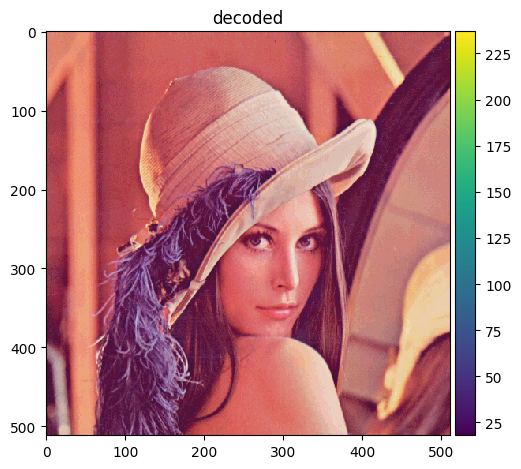

In [16]:
#gray_image.show(y, "decoded")
plt.figure()
plt.title("decoded")
io.imshow(y.astype(np.int16))
plt.show()

## Sorting the labels

In [17]:
def sort_labels(clusterer):
    centroids = clusterer.cluster_centers_.squeeze()
    idx = np.argsort(clusterer.cluster_centers_.sum(axis=1))
    lut = np.zeros_like(idx)
    lut[idx] = np.arange(len(centroids))
    argsort_lut = np.argsort(lut)
    sorted_centroids = centroids[argsort_lut]
    sorted_labels = lut[clusterer.labels_]
    centroids[:] = sorted_centroids
    clusterer.labels_ = sorted_labels

In [18]:
N_bins = 16
flatten_img = img.reshape((-1, 1))
clusterer = KMeans(n_clusters=N_bins, random_state=0)
clusterer.fit(flatten_img)
sort_labels(clusterer)
centroids = clusterer.cluster_centers_.squeeze()
k = clusterer.labels_.reshape(img.shape)

/home/vruiz/enviroments/SM/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


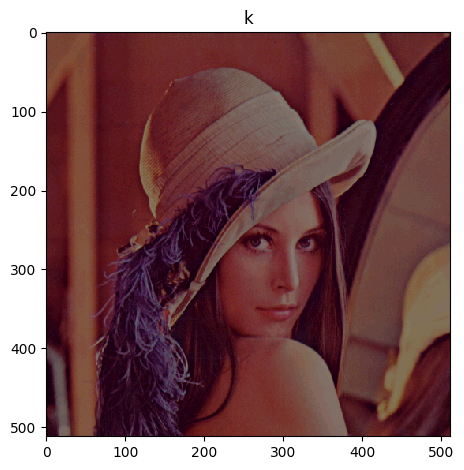

In [19]:
#gray_image.show_normalized(k, "k")
plt.figure()
plt.title('k')
io.imshow(k/np.linalg.norm(k)*255)
plt.show()

/home/vruiz/enviroments/SM/lib/python3.10/site-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


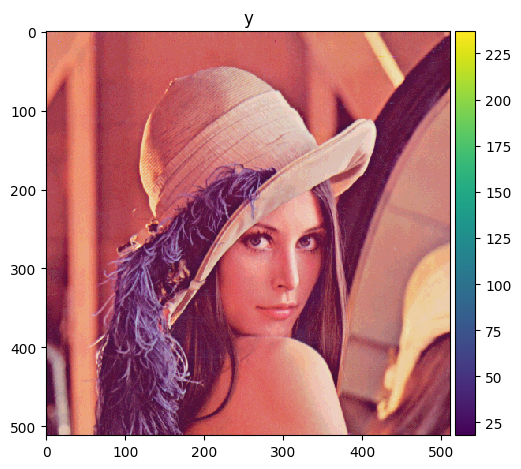

In [20]:
y = centroids[k]
#gray_image.show(y, "decoded")
plt.figure()
plt.title('y')
io.imshow(y.astype(np.int16))
plt.show()

## Quantization function

In [21]:
N_bins = 64
clusterer_img = KMeans(n_clusters=N_bins, random_state=0)
flatten_img = img.reshape(-1, 1)
sample = shuffle(flatten_img, random_state=0, n_samples=1_000)
clusterer_img.fit(sample)
sort_labels(clusterer_img)

/home/vruiz/enviroments/SM/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [22]:
x = np.linspace(0, 255, 256)

In [23]:
y = decode(clusterer_img, encode(clusterer_img, x))

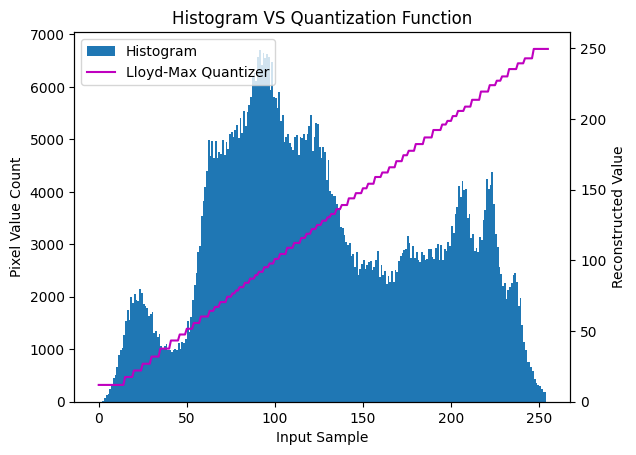

In [24]:
xlabel = "Input Sample"
ylabel = "Reconstructed Sample"
title = f"KMeans Quantizer ({fn}, $N\_bins={N_bins}$)"

ax1 = plt.subplot()
counts, bins = np.histogram(img, range(256))
l1 = ax1.bar(bins[:-1] - 0.5, counts, width=1, edgecolor='none')
ax2 = ax1.twinx()
l2, = ax2.plot(x, y, color='m')

plt.title("Histogram VS Quantization Function")
plt.legend([l1, l2], ["Histogram", "Lloyd-Max Quantizer"])
ax1.yaxis.set_label_text("Pixel Value Count")
ax2.yaxis.set_label_text("Reconstructed Value")
ax1.xaxis.set_label_text("Input Sample")
plt.show()

## Speed-up the clustering
We provide an initial partitioning based on the number of ocurrences inside of each bin.

In [25]:
def generate_initial_centroids(counts, N_bins):
    total_count = np.sum(counts)
    bin_count = total_count/N_bins
    initial_boundaries = [0.]
    acc = 0
    counter = 0
    for p in counts:
        acc += p
        counter += 1
        if acc > bin_count:
            initial_boundaries.append(float(counter))
            acc = 0
    initial_boundaries.append(256.)
    initial_boundaries = np.array(initial_boundaries)
    initial_centroids = 0.5 * (initial_boundaries[1:] + initial_boundaries[:-1])
    return initial_centroids

In [26]:
histogram, bin_edges = np.histogram(img, bins=256, range=(0, 256))
N_bins =16
initial_centroids = generate_initial_centroids(histogram, N_bins).reshape(-1, 1)
clusterer_img = KMeans(n_clusters=initial_centroids.size, init=initial_centroids, n_init=1)
clusterer_img.fit(flatten_img)
sort_labels(clusterer_img)

In [27]:
x = np.linspace(0, 255, 256)
y = decode(clusterer_img, encode(clusterer_img, x))

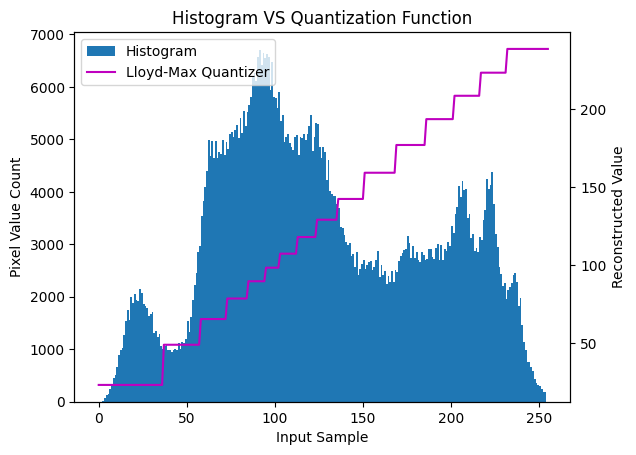

In [28]:
xlabel = "Input Sample"
ylabel = "Reconstructed Sample"
title = f"KMeans Quantizer ({fn}, $N\_bins={N_bins}$)"

ax1 = plt.subplot()
counts, bins = np.histogram(img, range(256))
l1 = ax1.bar(bins[:-1] - 0.5, counts, width=1, edgecolor='none')
ax2 = ax1.twinx()
l2, = ax2.plot(x, y, color='m')

plt.title("Histogram VS Quantization Function")
plt.legend([l1, l2], ["Histogram", "Lloyd-Max Quantizer"])
ax1.yaxis.set_label_text("Pixel Value Count")
ax2.yaxis.set_label_text("Reconstructed Value")
ax1.xaxis.set_label_text("Input Sample")
plt.show()

In [29]:
y = decode(clusterer_img, encode(clusterer_img, img.reshape(-1,1)))

/home/vruiz/enviroments/SM/lib/python3.10/site-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


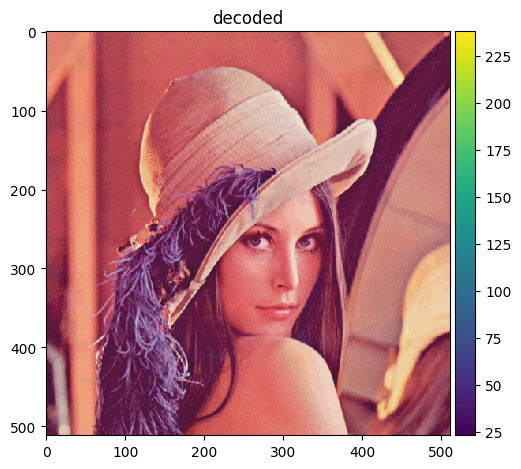

In [30]:
#gray_image.show(y.reshape(img.shape), "decoded")
plt.figure()
plt.title("decoded")
io.imshow(y.reshape(img.shape).astype(np.int16))
plt.show()

## Testing the library

In [31]:
#import KMeans_quantization as quantization
try:
    from scalar_quantization.KMeans_quantization import KMeans_Quantizer as Quantizer                          
    from scalar_quantization.KMeans_quantization import name as quantizer_name
except:
    !pip install "scalar_quantization @ git+https://github.com/vicente-gonzalez-ruiz/scalar_quantization"
    from scalar_quantization.KMeans_quantization import KMeans_Quantizer as Quantizer
    from scalar_quantization.KMeans_quantization import name as quantizer_name

  Cloning https://github.com/vicente-gonzalez-ruiz/scalar_quantization to /tmp/pip-install-wtzvias3/scalar-quantization_cce166e572cd4f7eb52bffe8e89f342f
  Running command git clone --filter=blob:none --quiet https://github.com/vicente-gonzalez-ruiz/scalar_quantization /tmp/pip-install-wtzvias3/scalar-quantization_cce166e572cd4f7eb52bffe8e89f342f
  Resolved https://github.com/vicente-gonzalez-ruiz/scalar_quantization to commit 7203778cb8f0d1169b8036ad142af0842830c470
  Running command git submodule update --init --recursive -q
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for scalar_quantization: filename=scalar_quantization-0.0.1-py3-none-any.whl size=9572 sha256=d634c8c7840286df69022ccbd9183b49d4074456516c0ff0d816ac39dc14c5c5
  Stored in directory: /tmp/pip-ephem-wheel-cache-bfjpbj7n/wheels/c2/72/38/68059694cec8e8c70710ffdfed70b257a172af1d258d476329
Successfully built scalar_quanti

In [32]:
counts, bins = np.histogram(img, range(256))
counts.shape

(255,)

In [33]:
Q_step = 128
#quantizer = quantization.KMeans_Quantizer
#Q = quantizer(Q_step=Q_step, counts=counts)
Q = Quantizer(Q_step=Q_step, counts=counts)
Q.fit(img.reshape(-1, 1))
print("decision_levels =", Q.get_decision_levels())
print("representation_levels =", Q.get_representation_levels())

decision_levels = [  0. 140. 255.]
representation_levels = [[ 88.87488024]
 [193.11312284]]


In [34]:
quantized_img, indexes = Q.encode_and_decode(img)

In [35]:
quantized_img.shape

(512, 512, 3, 1)

In [ ]:
#gray_image.show(quantized_img, "y")
plt.figure()
plt.title('y')
io.imshow(quantized_img.astype(np.int16))
plt.show()

## Ignore the rest

In [ ]:
input()

## Test KMeans

In [ ]:
from sklearn.cluster import KMeans

X = np.asarray([[1, 2], [1, 4], [1, 0],
                [4, 2], [4, 4], [4, 0]])

clusterer = KMeans(n_clusters=2, random_state=0)
#clusterer.fit(X)
Y = clusterer.fit_transform(X)
print("labels =", clusterer.labels_)
clusterer.predict([[0,0], [4,4]])
print("centers =", clusterer.cluster_centers_)
print("inertia =", clusterer.inertia_)
print(X, Y)
#clusterer.get_feature_names_out()
#clusterer.get_params()
clusterer.score(Y)

## Color Vector Quantization using KMeans

In [ ]:
# Authors: Robert Layton <robertlayton@gmail.com>
#          Olivier Grisel <olivier.grisel@ensta.org>
#          Mathieu Blondel <mathieu@mblondel.org>
#
# License: BSD 3 clause

import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin
from sklearn.datasets import load_sample_image
from sklearn.utils import shuffle
from time import time

n_colors = 64

# Load the Summer Palace photo
china = load_sample_image("china.jpg")

# Convert to floats instead of the default 8 bits integer coding. Dividing by
# 255 is important so that plt.imshow behaves works well on float data (need to
# be in the range [0-1])
china = np.array(china, dtype=np.float64) / 255

# Load Image and transform to a 2D numpy array.
w, h, d = original_shape = tuple(china.shape)
assert d == 3
image_array = np.reshape(china, (w * h, d))

print("Fitting model on a small sub-sample of the data")
t0 = time()
image_array_sample = shuffle(image_array, random_state=0, n_samples=1_000)
kmeans = KMeans(n_clusters=n_colors, random_state=0).fit(image_array_sample)
print(f"done in {time() - t0:0.3f}s.")

# Get labels for all points
print("Predicting color indices on the full image (k-means)")
t0 = time()
labels = kmeans.predict(image_array)
print(f"done in {time() - t0:0.3f}s.")


codebook_random = shuffle(image_array, random_state=0, n_samples=n_colors)
print("Predicting color indices on the full image (random)")
t0 = time()
labels_random = pairwise_distances_argmin(codebook_random, image_array, axis=0)
print(f"done in {time() - t0:0.3f}s.")


def recreate_image(codebook, labels, w, h):
    """Recreate the (compressed) image from the code book & labels"""
    return codebook[labels].reshape(w, h, -1)


# Display all results, alongside original image
plt.figure(1)
plt.clf()
plt.axis("off")
plt.title("Original image (96,615 colors)")
plt.imshow(china)

plt.figure(2)
plt.clf()
plt.axis("off")
plt.title(f"Quantized image ({n_colors} colors, K-Means)")
plt.imshow(recreate_image(kmeans.cluster_centers_, labels, w, h))

plt.figure(3)
plt.clf()
plt.axis("off")
plt.title(f"Quantized image ({n_colors} colors, Random)")
plt.imshow(recreate_image(codebook_random, labels_random, w, h))
plt.show()

## Voronoi diagram of the hand-written digits using K-means

In [ ]:
import numpy as np
from sklearn.datasets import load_digits

data, labels = load_digits(return_X_y=True)
(n_samples, n_features), n_digits = data.shape, np.unique(labels).size

print(f"# digits: {n_digits}; # samples: {n_samples}; # features {n_features}")

from time import time
from sklearn import metrics
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler


def bench_k_means(kmeans, name, data, labels):
    """Benchmark to evaluate the KMeans initialization methods.

    Parameters
    ----------
    kmeans : KMeans instance
        A :class:`~sklearn.cluster.KMeans` instance with the initialization
        already set.
    name : str
        Name given to the strategy. It will be used to show the results in a
        table.
    data : ndarray of shape (n_samples, n_features)
        The data to cluster.
    labels : ndarray of shape (n_samples,)
        The labels used to compute the clustering metrics which requires some
        supervision.
    """
    t0 = time()
    estimator = make_pipeline(StandardScaler(), kmeans).fit(data)
    fit_time = time() - t0
    results = [name, fit_time, estimator[-1].inertia_]

    # Define the metrics which require only the true labels and estimator
    # labels
    clustering_metrics = [
        metrics.homogeneity_score,
        metrics.completeness_score,
        metrics.v_measure_score,
        metrics.adjusted_rand_score,
        metrics.adjusted_mutual_info_score,
    ]
    results += [m(labels, estimator[-1].labels_) for m in clustering_metrics]

    # The silhouette score requires the full dataset
    results += [
        metrics.silhouette_score(
            data,
            estimator[-1].labels_,
            metric="euclidean",
            sample_size=300,
        )
    ]

    # Show the results
    formatter_result = (
        "{:9s}\t{:.3f}s\t{:.0f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}"
    )
    print(formatter_result.format(*results))

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

print(82 * "_")
print("init\t\ttime\tinertia\thomo\tcompl\tv-meas\tARI\tAMI\tsilhouette")

kmeans = KMeans(init="k-means++", n_clusters=n_digits, n_init=4, random_state=0)
bench_k_means(kmeans=kmeans, name="k-means++", data=data, labels=labels)

kmeans = KMeans(init="random", n_clusters=n_digits, n_init=4, random_state=0)
bench_k_means(kmeans=kmeans, name="random", data=data, labels=labels)

pca = PCA(n_components=n_digits).fit(data)
kmeans = KMeans(init=pca.components_, n_clusters=n_digits, n_init=1)
bench_k_means(kmeans=kmeans, name="PCA-based", data=data, labels=labels)

print(82 * "_")

import matplotlib.pyplot as plt

reduced_data = PCA(n_components=2).fit_transform(data)
kmeans = KMeans(init="k-means++", n_clusters=n_digits, n_init=4)
kmeans.fit(reduced_data)

# Step size of the mesh. Decrease to increase the quality of the VQ.
h = 0.02  # point in the mesh [x_min, x_max]x[y_min, y_max].

# Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Obtain labels for each point in mesh. Use last trained model.
Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(1)
plt.clf()
plt.imshow(
    Z,
    interpolation="nearest",
    extent=(xx.min(), xx.max(), yy.min(), yy.max()),
    cmap=plt.cm.Paired,
    aspect="auto",
    origin="lower",
)

plt.plot(reduced_data[:, 0], reduced_data[:, 1], "k.", markersize=2)
# Plot the centroids as a white X
centroids = kmeans.cluster_centers_
plt.scatter(
    centroids[:, 0],
    centroids[:, 1],
    marker="x",
    s=169,
    linewidths=3,
    color="w",
    zorder=10,
)
plt.title(
    "K-means clustering on the digits dataset (PCA-reduced data)\n"
    "Centroids are marked with white cross"
)
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.show()